# Goal

In the "time_series_covid_19_confirmed.csv" file, I have the time series numbers of coronavirus confirmed cases for different provinces/states in different countries/regions. That's what make me think of this question. Since the situation has already developed quite a lot in China, and different provinces in china actually adopted actions of different levels towards coronavirus precaution, and thus led to different result. Despite the efforts of Chinese people, the coronavirus is inevitably spreading globally, and we don't know where the world is going. This make me think of, can I cluster the time series for different areas and get some insights from it to see what the situation in other areas is going to be like.

I am going to use k-means clustering algorithm, a classic unsupervised classfication technique.

Since the start of spreading in different areas varies, I am just using the data from 100 cases to 500 cases of different areas, calculate the confirmed cases growth rate. By doing so, the length of different series will vary, so I am using the Dynamic Time Warping (DTW) technique to align them and measure similarity between every two series.

With a good similarity measure, small changes in two time series should result in small changes in their similarity.  With respect to Euclidean distance this is true for changes in the y-axis, but it is not true for changes in the time axis (i.e. compression and stretching).  Consider the following example.

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Plot formatting
plt.rcParams['font.size'] = 8
plt.figure(figsize = (40, 8))

<Figure size 2880x576 with 0 Axes>

<Figure size 2880x576 with 0 Axes>

In [246]:
import os

In [247]:
filePath = r'C:\Users\hhhua\play\walmart\Walmart_MI_ML_interview_campus-master\data'
dataname_list = os.listdir(filePath)

In [248]:
dataname_list

['2019_nCoV_data.csv',
 'COVID19_line_list_data.csv',
 'COVID19_open_line_list.csv',
 'covid_19_data.csv',
 'time_series_covid_19_confirmed.csv',
 'time_series_covid_19_deaths.csv',
 'time_series_covid_19_recovered.csv']

In [249]:
data_list = [pd.read_csv(filePath+'\\'+x) for x in dataname_list]

# Exploratory Data Analysis

In [250]:
confirm, death, recover = data_list[4], data_list[5], data_list[6]

In [251]:
confirm.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20
0,Anhui,Mainland China,31.82571,117.2264,1,9,15,39,60,70,...,860,889,910,934,950,962,973,982,986,987
1,Beijing,Mainland China,40.18238,116.4142,14,22,36,41,68,80,...,342,352,366,372,375,380,381,387,393,395
2,Chongqing,Mainland China,30.05718,107.8740,6,9,27,57,75,110,...,505,518,529,537,544,551,553,555,560,567
3,Fujian,Mainland China,26.07783,117.9895,1,5,10,18,35,59,...,267,272,279,281,285,287,290,292,293,293
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,86,87,90,90,90,90,91,91,91,91


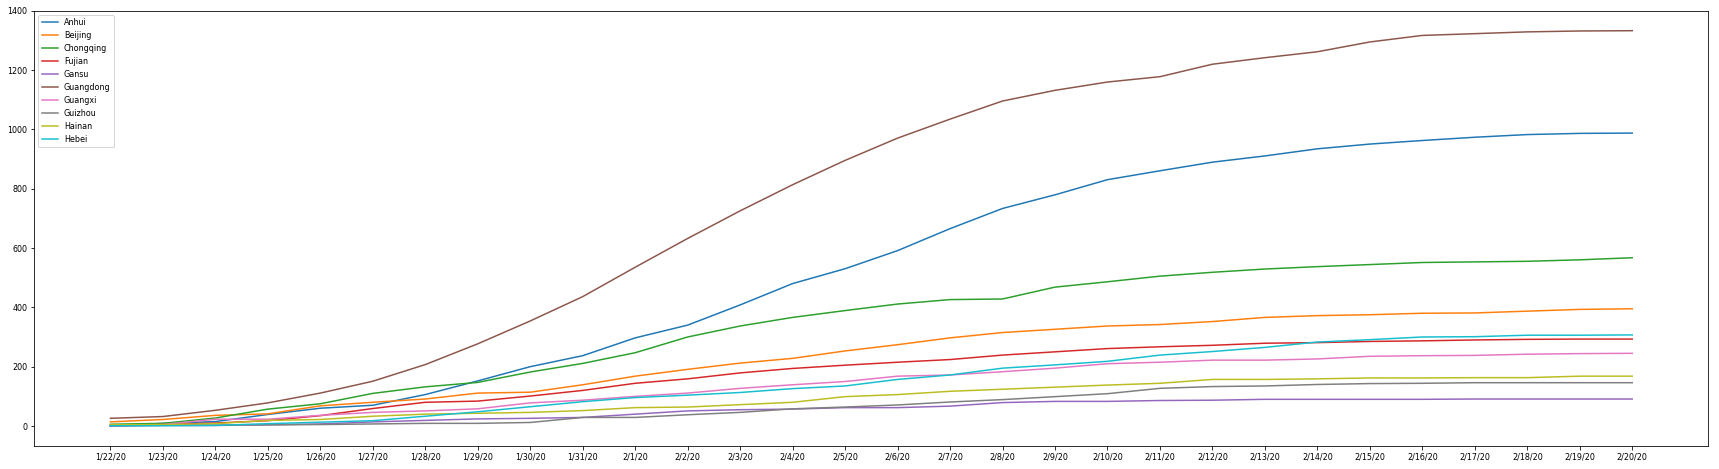

In [252]:
plt.figure(figsize=(30,8))
plt.plot(confirm.iloc[:10,4:].T)
plt.legend(confirm["Province/State"][:10])

In [253]:
confirm_cn = confirm[confirm["Country/Region"]=="Mainland China"].iloc[:, 4:].copy()

In [228]:
cn_region = confirm[confirm["Country/Region"]=="Mainland China"]["Province/State"]

In [254]:
confirm_cn = confirm_cn[(confirm_cn>=100) & (confirm_cn<=1000)]

In [255]:
confirm_cn.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20
0,NaN,NaN,NaN,NaN,NaN,NaN,106.0,152.0,200.0,237.0,...,860.0,889.0,910.0,934.0,950.0,962.0,973.0,982.0,986.0,987.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,114.0,139.0,...,342.0,352.0,366.0,372.0,375.0,380.0,381.0,387.0,393.0,395.0
2,NaN,NaN,NaN,NaN,NaN,110.0,132.0,147.0,182.0,211.0,...,505.0,518.0,529.0,537.0,544.0,551.0,553.0,555.0,560.0,567.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,120.0,...,267.0,272.0,279.0,281.0,285.0,287.0,290.0,292.0,293.0,293.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
growth_rate = confirm_cn.diff(axis = 1, periods = 1) /confirm_cn.shift(axis=1)

In [257]:
# growth_rate = growth_rate[(confirm_cn.values>=100) & (confirm_cn.values<=500)]

In [258]:
growth_rate.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433962,0.315789,0.185000,...,0.036145,0.033721,0.023622,0.026374,0.017131,0.012632,0.011435,0.009250,0.004073,0.001014
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027027,0.219298,...,0.014837,0.029240,0.039773,0.016393,0.008065,0.013333,0.002632,0.015748,0.015504,0.005089
2,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.113636,0.238095,0.159341,...,0.039095,0.025743,0.021236,0.015123,0.013035,0.012868,0.003630,0.003617,0.009009,0.012500
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188119,...,0.022989,0.018727,0.025735,0.007168,0.014235,0.007018,0.010453,0.006897,0.003425,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
growth_rate.index = cn_region

In [260]:
num_of_gr = (~growth_rate.isnull()).sum(axis = 1)

In [261]:
filtered_gr = growth_rate.loc[(num_of_gr[num_of_gr>=5]).index]

In [262]:
filtered_gr.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20
Province/State,,,,,,,,,,,,,,,,,,,,,
Anhui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433962,0.315789,0.185000,...,0.036145,0.033721,0.023622,0.026374,0.017131,0.012632,0.011435,0.009250,0.004073,0.001014
Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027027,0.219298,...,0.014837,0.029240,0.039773,0.016393,0.008065,0.013333,0.002632,0.015748,0.015504,0.005089
Chongqing,NaN,NaN,NaN,NaN,NaN,NaN,0.200000,0.113636,0.238095,0.159341,...,0.039095,0.025743,0.021236,0.015123,0.013035,0.012868,0.003630,0.003617,0.009009,0.012500
Fujian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188119,...,0.022989,0.018727,0.025735,0.007168,0.014235,0.007018,0.010453,0.006897,0.003425,0.000000
Guangdong,NaN,NaN,NaN,NaN,NaN,0.36036,0.370861,0.338164,0.277978,0.231638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
growth_rate_list = []
for index, row in filtered_gr.iterrows():
    growth_rate_list.append(row.values[~np.isnan(row.values)])
    

In [264]:
# one of growth rate sequence
growth_rate_list[0]

array([0.43396226, 0.31578947, 0.185     , 0.25316456, 0.14478114,
       0.2       , 0.17647059, 0.10416667, 0.11509434, 0.12521151,
       0.10225564, 0.0627558 , 0.06546855, 0.03614458, 0.03372093,
       0.02362205, 0.02637363, 0.01713062, 0.01263158, 0.01143451,
       0.00924974, 0.00407332, 0.0010142 ])

In [265]:
def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

## Dynamic Time Warping

Dynamic time warping finds the optimal non-linear alignment between two time series.  The Euclidean distances between alignments are then much less susceptable to pessimistic similarity measurements due to distortion in the time axis.  There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used.

Dynamic time warping works in the following way. Consider two time series $Q$ and $C$ of the same length $n$ where $$Q=q_1,q_2,...,q_n$$ and $$C=c_1,c_2,...,c_n$$ The first thing we do is construct an $n\times n$ matrix whose $i,j^{th}$ element is the Euclidean distance between $q_i$ and $c_j$.  We want to find a path through this matrix that minimizes the cumulative distance.  This path then determines the optimal alignment between the two time series.  It should be noted that it is possible for one point in a time series to be mapped to multiple points in the other time series.

Let's call the path $W$ where $$W=w_1,w_2,...,w_K$$ where each element of $W$ represents the distance between a point $i$ in $Q$ and a point $j$ in $C$ i.e. $w_k=(q_i-c_j)^2$

So we want to find the path with the minimum Euclidean distance $$W^*=argmin_W(\sqrt{\sum_{k=1}^Kw_k})$$ The optimal path is found via dynamic programming, specifically the following recursive function. $$\gamma(i,j)=d(q_i,c_j)+min ( \gamma(i-1,j-1),\gamma(i-1,j),\gamma(i,j-1))$$ 

In [266]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

Now let's compute the Euclidean distance between $ts1$ and $ts2$ using dynamic time warping.

In [267]:
print(DTWDistance(growth_rate_list[0], growth_rate_list[1]))

0.43032620825634865


### Speeding Up Dynamic Time Warping

Dynamic time warping has a complexity of $O(nm)$ where $n$ is the length of the first time series and $m$ is the length of the second time series.  If you are performing dynamic time warping multiple times on long time series data, this can be prohibitively expensive.  However, there are a couple of ways to speed things up.  The first is to enforce a locality constraint.  This works under the assumption that it is unlikely for $q_i$ and $c_j$ to be matched if $i$ and $j$ are too far apart.  The threshold is determined by a window size $w$.  This way, only mappings within this window are considered which speeds up the inner loop. The following is the modified code which includes the window size $w$.

In [268]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

Let's test this faster version.

Another way to speed things up is to use the _LB Keogh_ lower bound of dynamic time warping.  It is defined as $$LBKeogh(Q,C)=\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i)$$
where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$ which are defined as $U_i=max(q_{i-r}:q_{i+r})$ and $L_i=min(q_{i-r}:q_{i+r})$ for a reach $r$ and $I(\cdot)$ is the indicator function. It can be implemented with the following function.

In [269]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    if len(s1)>len(s2):
        s1, s2 = s2, s1
    for ind,i in enumerate(s1):
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

The _LB Keogh_ lower bound method is linear whereas dynamic time warping is quadratic in complexity which make it very advantageous for searching over large sets of time series. 

## Classification and Clustering

Now that we have a reliable method to determine the similarity between two time series, we can use the k-NN algorithm for classification.  Empirically, the best results have come when $k=1$.  The following is the 1-NN algorithm that uses dynamic time warping Euclidean distance.  In this algorithm, $train$ is the training set of time series examples where the class that the time series belongs to is appended to the end of the time series.  $test$ is the test set whose corresponding classes you are trying to predict.  In this algorithm, for every time series in the test set, a search must be performed through all points in the training set so that the most similar point is found.  Given that dynamic time warping is quadratic, this can be very computationally expensive.  We can speed up classification using the _LB Keogh_ lower bound.  Computing _LB Keogh_ is much less expensive than performing dynamic time warping.  And since $LB Keogh(Q,C) \leq DTW(Q,C)$ , we can eliminate time series that cannot possibly be more similar that the current most similar time series. In this way we are eliminating many unnecessary dynamic time warping computations.

Now let's test it on some data. We will use a window size of 4.  Although the code is sped up with the use of the _LB Keogh_ bound and the dynamic time warping locality contraint, it may still take a few minutes to run.

The same idea can also be applied to k-means clustering.  In this algorithm, the number of clusters is set _apriori_ and similar time series are clustered together.

In [270]:
import numpy as np
import pickle
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [271]:
def EuclidDistance(s1,s2):
    Len1 = len(s1)
    Len2 = len(s2)
    if Len1 != Len2:
        print('Warring: Difference of Dimension!')
    return np.sqrt(sum(np.subtract(s1,s2)**2))


def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
# The Dynamic Time Warping (DTW) is a popular similarity measure between time series. 
# The DTW fails to satisfy the triangle inequality and its computation requires quadratic  time.  
# Hence,  to  find  closest  neighbors  quickly,  we  use  bounding  tech-niques.
# We can avoid most DTW computations with an inexpensive lower bound (LB Keogh)
    LB_sum=0
    if len(s1)>=len(s2):
        s1, s2 = s2, s1
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)


def k_means_clust(data,num_clust, w=5, min_Cent=3):
    centroids = random.sample(data,num_clust)
    #old_centroids = np.add(new_centroids,10)
    counter=0
    assignments={}
    while True:
        counter+=1
        #print('iter: {it}'.format(it=counter))
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,w) < min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist < min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
        #print('Round-{r} Centroids : {cents}'.format(r=counter, cents=str(centroids)))
        print('Round-{r}'.format(r=counter))
        old_centroids = centroids
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(len(data[0]))
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
        isConvergence = True
        for i in range(num_clust):
            if EuclidDistance(old_centroids[i], centroids[i]) != 0:
                isConvergence = False
                break
        if isConvergence:
            break
        #ss = 0
        #for key in groups:    
        #    for each in clus[key]:
        #        ss = ss + EuclidDistance(each,center[key])
    print('\n======== Fianl Assignments ================================')
    print('{result}'.format(result=str(assignments)))
    return assignments


def k_means_clust_v2(data,num_clust, w=5, min_CentNum=3, min_CentRate=0.1,
                     showAssignments=False, show_excTime=True):
    if show_excTime:
        start_time = time.time()
    centroids = random.sample(list(range(len(data))), num_clust)
    counter = 0
    assignments = {}
    while True:
        counter+=1
        assignments = {}
        for idx in centroids:
            assignments[idx] = [idx]
        #assign data points to clusters
        for idx, ts in enumerate(data):
            if idx in centroids:
                continue
            min_dist = float('inf')
            closest_clust = None
            for c_idx in centroids:
                if LB_Keogh(ts, data[c_idx], w) < min_dist:
                    cur_dist = DTWDistance(ts, data[c_idx], w)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_idx
            assignments[closest_clust].append(idx)
        print('Round-{r} Centroids Index : {cents}'.format(r=counter, cents=str(centroids)))
        old_centroids = centroids
        centroids = []
        #print(assignments)
        #recalculate centroids of clusters
        for c_idx in assignments:
            group_members = assignments[c_idx]
            sample_CentNum = max(min_CentNum, int(len(assignments[c_idx])*min_CentRate))
            sample_CentNum = min(sample_CentNum, len(assignments[c_idx]))
            #print('{gid} sample_cen = {sc}'.format(gid=key, sc=sample_cen))
            cent_candidate = random.sample(group_members[1:], sample_CentNum-1)
            
            new_cent = group_members[0]
            err=  0
            for idx in group_members:
                err += DTWDistance(data[new_cent], data[idx], w)
            min_dist = err / len(group_members)
            for i in range(sample_CentNum-1):
                cand_cent = cent_candidate[i]
                err = 0
                for idx in group_members:
                    err += DTWDistance(data[cand_cent], data[idx], w)
                avg_err = err / len(group_members)
                if avg_err < min_dist:
                    new_cent = cent_candidate[i]
                    min_dist = avg_err
            centroids.append(new_cent)
            
        isConvergence = True
        for i in range(num_clust):
            if centroids[i] != old_centroids[i]:
                isConvergence = False
                break
        if isConvergence:
            break
    
    if showAssignments:
        print('\n======== Fianl Assignments ================================')
        for cent_idx in assignments:
            print('{c} : {g}'.format(c=cent_idx, g=str(assignments[cent_idx])))
    else:
        print('\n======== Fianl Centroids ================================')
        print('Centroids Index : {cents}'.format(cents=str(list(assignments.keys()))))

    if show_excTime:
        print('\n======== Execution Time =================================')
        print("{t} seconds ".format(t=(time.time()-start_time)))
    
    return assignments


def plt_TimeSeries(time_series_list):
    xx = range(len(time_series_list[0]))
    for ts in time_series_list:
        plt.plot(xx, ts)
    plt.show()

def plt_ClusterTimeSeries(time_series_list, assignments):
    xx = range(len(time_series_list[0]))
    num_plt = len(assignments.keys())
    plt_count = 0
    plt.figure(figsize=(15,4*num_plt))
    for cent in assignments:
        plt.subplot(num_plt,1,plt_count+1)
        cmap = plt.get_cmap('Blues')
        number = len(assignments[cent])
        colors = [cmap(i) for i in np.linspace(0.4, 0.6, number)]
        for i, idx in enumerate(assignments[cent]):
            yy = time_series_list[idx]
            plt.plot(xx, yy, color=colors[i])
        yy = time_series_list[cent]
        plt.plot(xx, yy, color='r')
        plt_count += 1
    plt.show()


In [272]:
groups =  k_means_clust_v2(growth_rate_list,num_clust=5,w=2)

KeyError: None

In [273]:
# Having difficulties debugging

# Further  Scope

try multivariate DTW, or use PCA to change multivariate sequence to single dimension